# Activity level selection problem
장사를 하면 다음과 같은 과정을 반복한다.  
장사꾼은 특정 물건들을 판다.  
그리고 특정 물건들은 할인을 하게 된다.  
장사꾼의 행동 수준이 자원들의 공급과 수요에 영향을 준다.  
장사꾼은 수익을 얻는다.  

장사꾼이 결정할 수 없는 내용은 아래와 같다.  
 - 장사꾼의 행동 수준에 따른 자원들의 공급과 수요 영향  
 - 자원들의 총량  
 - 상품들의 가격과 할인가격  
 - 할인 행동 수준  
 
장사꾼이 결정할 것  
 - 판매 행동 수준  
 
한정된 resource가 있을때 revenue 를 높이는 action의 수준을 선택하는 문제를 최적화를 통해서 풀어보자.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
np.set_printoptions(formatter={'float_kind': lambda x: "{: 0.2f}".format(x)})
# np.set_printoptions(precision=2)
cp.__version__

'1.1.7'

## Problem definition

notation은 다음과 같다.

 - 판매 행동 수준 $x > 0$  
 - 행동 수준 개수: n  
 - 자원 개수 : m  
 - 행동과 자원의 상관관계 : A  
     > $A_{ij} \geq 0$ : activity j가 resoure i를 발생   
     > $A_{ij} \leq 0$ : activity j가 resoure i를 소비   
 - 자원들의 총량: $c^{max}$  
 - 행동에 대한 기본 가격과 수량 할인 가격 $p > 0,  0 < p^{disc} < p$  
 - 할인 행동 수준 $q > 0$  
 - 행동에 대한 수익: $r$  
 
### Design of constraints
 - Total consumption of resoure i:  
 > $c_{i} = \sum_{j=1}^{n}A_{ij}x_{j} $
 - each resources are limited:
 > $c_{i} \leq c_{i}^{max}$
 
위의 상황에서 constraint는 다음과 같다.  
$$
\begin{align}
\sum_{j=1}^{n}A_{ij}x_{j} &\leq c_{i}^{max} \;\; for \; i = 1,\cdots,m \\ 
&x_{j} > 0 \;\; for \; j = 1,\cdots,n \\ 
\end{align}
$$

matrix form으로는 아래와 같다.
$$
\begin{align}
Ax &\leq c^{max} \\ 
x &> 0 \\ 
\end{align}
$$

### Design of objective function
 - 행동에 대한 수익함수는 다음과 같이 정의 할 수 있다.
$$
r_{j}(x_{j}) = \begin{cases} 
p_{j}x_{j} & 0 \leq x_{j} \leq q_{j} \\
p_{j}q_{j} + p_{j}^{disc}(x_{j}-q_{j}) \geq q_{j}
\end{cases}
$$
행동 수준이 할인 행동수준보다 낮을 때는 기본가격에 판다.  
하지만 높아졌을 때 할인가격에 판다.  
수익 그래프의 기울기가 기본가격에서 할인가격으로 바뀐다.  
기울기가 감소했으니가 concave한 형태이다.  

 - Total revenue:
 > $\sum_{j=1}^{n}r_{j}(x_{j})$
 
### Optimization problem
위에서 디자인한 objective와 constraint를 사용하여 최적화식을 formulation해보자.
$$
\underset{x_{1}, \cdots, x_{n}}{max} \sum_{j=1}^{n}r_{j}(x_{j})\;\; s.t. \\
\;\; \sum_{j=1}^{n}A_{ij}x_{j} \leq c_{i}^{max} \;\; for \; i = 1,\cdots,m \\ 
x_{j} > 0 \;\; for \; j = 1,\cdots,n \\ 
$$

## Implemetation

### Initialize values

In [2]:
A = np.array([[1, 2, 0, 1],
             [0, 0, 3, 1],
             [0, 3, 1, 1],
             [2, 1, 2, 5],
             [1, 0, 3, 2]])
cmax = np.array([100, 100, 100, 100, 100]).reshape(-1,1)
p = np.array([ 3, 2, 7, 6 ]).reshape(-1,1)
pdisc = np.array([2, 1, 4, 2]).reshape(-1,1)
q = np.array([4, 10, 5, 10 ]).reshape(-1,1)

### Plot revanue function

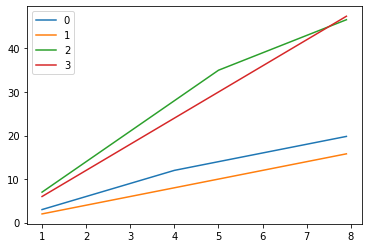

In [3]:
def revenue(x, p, q, pdisc):
    a = p * x
    b = p * q + pdisc * (x - q)
    a = np.expand_dims(a,axis=0)
    b = np.expand_dims(b,axis=0)
    out = np.concatenate([a,
                     b],axis=0)    
    out = np.min(out, axis=0)    
    return out
for i in range(len(p)):
    plt.plot(np.arange(1,8,0.1),
             revenue(x = np.arange(1,8,0.1),p=p,q=q,pdisc=pdisc)[i], label=str(i))
plt.legend()

위에 보이듯이 함수가 concave한 형태임을 알 수 있다.

In [4]:
class activate_selector():    
    def __init__(self, A, cmax, p, pdisc, q):
        self.A = A # m,n
        self.cmax = cmax # m,1
        self.p = p # n,1
        self.pdisc = pdisc # n,1
        self.q = q # n,1
        self.m, self.n = A.shape
        
        self.x = cp.Variable(shape=(self.n,1)) # n,1
        self.total_revenue = cp.sum(self.get_revenue(self.x))
        self.constraints = [self.A @ self.x <= self.cmax]
        self.constraints += [self.x  >= 0]
        
    def solve(self):
        prob = cp.Problem(cp.Maximize(self.total_revenue), constraints=self.constraints)
        prob.solve()
        
    def print_result(self):
        print("The optimal input is \n{}".format(self.x.value))
        r = cp.reshape(self.get_revenue(self.x), shape=(self.n,1))
        print("\nThe revenue is \n{}".format(r.value))
        t_r = cp.sum(r)
        print("\nThe total revenue is \n{:0.2f}".format(t_r.value))
        avg_p = r / self.x
        print("\nThe average price is \n{}".format(avg_p.value))
        
    def get_revenue(self, x):
        a = cp.multiply(self.p, x)
        b = self.p * self.q + cp.multiply(self.pdisc,(x - self.q))
        out = cp.min(cp.hstack([a,b]), axis=1)
        return out
             

In [5]:
activate_selector = activate_selector(A, cmax, p, pdisc, q)
activate_selector.solve()
activate_selector.print_result()

The optimal input is 
[[ 4.00]
 [ 22.50]
 [ 31.00]
 [ 1.50]]

The revenue is 
[[ 12.00]
 [ 32.50]
 [ 139.00]
 [ 9.00]]

The total revenue is 
192.50

The average price is 
[[ 3.00]
 [ 1.44]
 [ 4.48]
 [ 6.00]]


###  결과분석
3번째 resource의 basic price가 높고 
discount activity level이 높으며 수익의 대부분을 차지하기 때문에 
3번째 action level이 높은 것을 볼 수 있다.
반면 4번째 resource의 할인가격이 기본가격에 비해 매우 낮고
많은 자원을 소비하며 수익의 가장 작은 부분을 차지하기 때문에
4번째 행동수준이 낮은것을 볼수있다.